# Metodo Sparse General

In [10]:
# Cargar herramientas para manejo de video
from video_tools import load_video, save_demo_video
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
D = load_video('test.avi')

In [12]:
def augmented_lagrangian(L, S, Y, mu, lamb, D):
    nuc = np.linalg.norm(L, ord='nuc')
    l1 = np.linalg.norm(S.flatten(), ord=1)
    tmp = D - L - S
    frob = np.linalg.norm(tmp, ord='fro')
    return nuc + lamb * l1 + np.sum(Y * tmp) + 0.5 * mu * frob ** 2


def J(Y, lamb):
    return max(np.linalg.norm(Y), 1/lamb * np.linalg.norm(Y))


def soft_threshold(X, eps):
    out = np.zeros(X.shape)
    out[X > eps] = X[X > eps] - eps
    out[X < -eps] = X[X < -eps] + eps
    return out


def video_segmentation(D, max_iter=500, mu_0=0.001, lamb=0.01):
    Y_k = D / J(D, lamb)
    S_k = D - Y_k
    #S_k = np.zeros(D.shape)

    err = [] 
    for i in range(1, max_iter):
        mu_k = mu_0 * i  # mu_i crece de forma lineal

        print("Iteracion {}".format(i))
        # Resolver L_{k+1} = argmin_L L(L, S_k, Y_k, mu_k)
        U, S, V = np.linalg.svd(D - S_k + (1 / mu_k) * Y_k, full_matrices=False)
        S_shrink = soft_threshold(S, (1 / mu_k))
        L_k = np.dot(U * S_shrink, V)

        # Resolver S_{k+1} = argmin_S L(L_k, S, Y_k, mu_k)
        S_k = soft_threshold(D - L_k + (1 / mu_k) * Y_k , lamb / mu_k)

        # Paso en valor del dual
        Y_k += mu_k * (D - L_k - S_k)
        print(augmented_lagrangian(L=L_k, S=S_k, lamb=lamb, mu=mu_k, Y=Y_k, D=D))

        err.append(np.linalg.norm(D - L_k - S_k, ord='fro') / np.linalg.norm(D, ord='fro'))
        #if err[-1] < 1e-10:
        #    print('Method converged in iteration {}'.format(i))
        #    break


    L = L_k.copy()
    S = S_k.copy()
    
    return L, S, err

In [13]:
L, S, err = video_segmentation(D, max_iter=500, mu_0=.001, lamb=0.01)

Iteracion 1
491837.979774
Iteracion 2
328583.603067
Iteracion 3
304276.53106
Iteracion 4
286046.227058
Iteracion 5
271461.983858
Iteracion 6
259308.447859
Iteracion 7
248891.131288
Iteracion 8
239775.979289
Iteracion 9
231673.621957
Iteracion 10
224381.500358
Iteracion 11
217752.298905
Iteracion 12
211675.530906
Iteracion 13
206066.2066
Iteracion 14
200857.548315
Iteracion 15
195996.133916
Iteracion 16
191438.557917
Iteracion 17
187149.074624
Iteracion 18
183097.895958
Iteracion 19
179259.937222
Iteracion 20
175613.876423
Iteracion 21
172141.437567
Iteracion 22
168826.83684
Iteracion 23
165656.349189
Iteracion 24
162617.96519
Iteracion 25
159701.116551
Iteracion 26
156896.454397
Iteracion 27
154195.66862
Iteracion 28
151591.339478
Iteracion 29
149076.814789
Iteracion 30
146646.10759
Iteracion 31
144293.8103
Iteracion 32
142015.022301
Iteracion 33
139805.288483
Iteracion 34
137660.546837
Iteracion 35
135577.083523
Iteracion 36
133551.49419
Iteracion 37
131580.650515
Iteracion 38
129661.

63672.0324666
Iteracion 300
63672.0324666
Iteracion 301
63672.0324666
Iteracion 302
63672.0324666
Iteracion 303
63672.0324666
Iteracion 304
63672.0324666
Iteracion 305
63672.0324666
Iteracion 306
63672.0324666
Iteracion 307
63672.0324666
Iteracion 308
63672.0324666
Iteracion 309
63672.0324666
Iteracion 310
63672.0324666
Iteracion 311
63672.0324666
Iteracion 312
63672.0324666
Iteracion 313
63672.0324666
Iteracion 314
63672.0324666
Iteracion 315
63672.0324666
Iteracion 316
63672.0324666
Iteracion 317
63672.0324666
Iteracion 318
63672.0324666
Iteracion 319
63672.0324666
Iteracion 320
63672.0324666
Iteracion 321
63672.0324666
Iteracion 322
63672.0324666
Iteracion 323
63672.0324666
Iteracion 324
63672.0324666
Iteracion 325
63672.0324666
Iteracion 326
63672.0324666
Iteracion 327
63672.0324666
Iteracion 328
63672.0324666
Iteracion 329
63672.0324666
Iteracion 330
63672.0324666
Iteracion 331
63672.0324666
Iteracion 332
63672.0324666
Iteracion 333
63672.0324666
Iteracion 334
63672.0324666
Iterac

# Plot error

El criterio de convergencia del Liu no aplica porque la igualdad $L+S=D$ se cumple desde muy temprano en el algoritmo

Text(0.5,1,'Error relativo en norma Frobenius (Liu)')

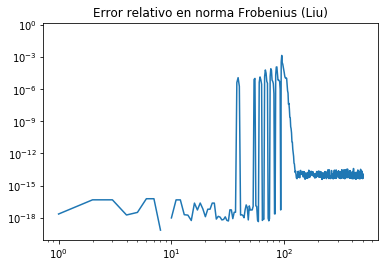

In [15]:
plt.loglog(err)
plt.title('Error relativo en norma Frobenius (Liu)')

# Ejemplos de frames del resultado

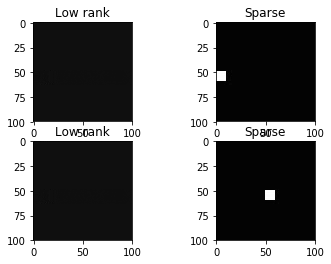

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot('221')
plt.title('Low rank')
plt.imshow(L[:, 0].reshape(100,100), cmap='gray')

plt.subplot('222')
plt.title('Sparse')
plt.imshow(S[:, 0].reshape(100,100), cmap='gray')

plt.subplot('223')
plt.title('Low rank')
plt.imshow(L[:, 50].reshape(100,100), cmap='gray')

plt.subplot('224')
plt.title('Sparse')
plt.imshow(S[:, 50].reshape(100,100), cmap='gray')

# Save Video

In [21]:
import cv2
import numpy as np

save_demo_video('demo.avi', D, L, S)

Creating Video
Releasing Video
